# アンテナログから時刻と$Az, El$を読み取って、$(l, b), (\alpha, \delta)$に座標変換してプロット

## 観測テーブル　AZEL　→　LB　座標変換

In [2]:
import time
from astropy.coordinates import SkyCoord, ICRS, Galactic, EarthLocation, AltAz
import astropy.units as u
from astropy.time import Time

def set_OBS_LOCATION(OBS_LON, OBS_LAT, OBS_HEI):
    global OBS_LOCATION

    OBS_LOCATION = EarthLocation(lon=OBS_LON*u.deg,
                                 lat=OBS_LAT*u.deg,
                                 height=OBS_HEI*u.m)

    return

def transform_AZEL(obs_dt, AZ, EL):
    '''
    (return)\n
    ra_deg, dec_deg, gl_deg, gb_deg, EQUINOX
    '''

    obs_Time = Time(obs_dt.timestamp(), format='unix')

    obs_coord_AZEL = AltAz(az= AZ * u.degree,
                           alt= EL * u.degree,
                           obstime= obs_Time,
                           location= OBS_LOCATION)
    obs_coord_AZEL = SkyCoord(obs_coord_AZEL)

    #debug---
    #print(obs_coord_AZEL)
    #--------

    #calculate error catch time ---
    start = time.time()
    #------------------------------

    while True:
        try:
            obs_coord_RADEC = obs_coord_AZEL.transform_to(ICRS)
        except ValueError:
            Error_catch_end = time.time()
            print('Error_catch_time: {}s\n'.format(Error_catch_end - start))
        else:
            break

    #obs_coord_RADEC = obs_coord_AZEL.transform_to(ICRS)  # move to inside try-statement
    ra_deg  = obs_coord_RADEC.icrs.ra.deg
    dec_deg = obs_coord_RADEC.icrs.dec.deg
    EQUINOX = 'J2000'  #the equinox of ICRS is 'J2000'

    obs_coord_GLGB = obs_coord_AZEL.transform_to(Galactic)
    gl_deg = obs_coord_GLGB.l.deg
    gb_deg = obs_coord_GLGB.b.deg

    return ra_deg, dec_deg, gl_deg, gb_deg, EQUINOX

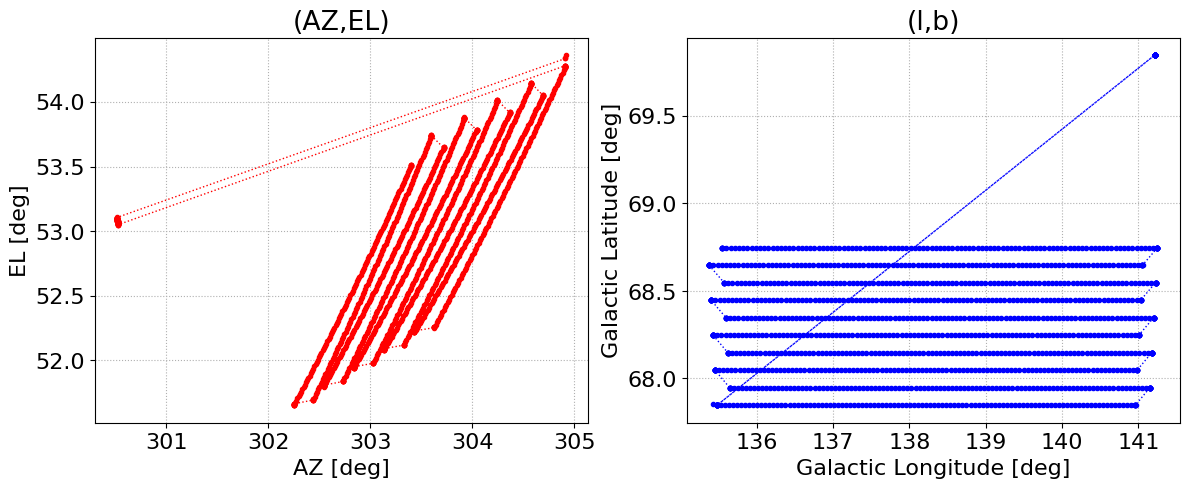

In [7]:
import pandas as pd
from datetime import datetime, timezone, timedelta
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams.update({'font.size': 16})
mpl.rcParams.update({'axes.grid': True})
mpl.rcParams.update({'grid.linestyle': ':'})

# JST -> UTC 変換関数
def jst_to_utc(jst_time):
    return jst_time.astimezone(timezone.utc)

def parse_date_to_utc(date_str):
    jst_time = datetime.strptime(date_str[1:24], '%Y/%m/%d-%H:%M:%S.%f')  # JSTで読み込む
    utc_time = jst_to_utc(jst_time)  # UTCに変換
    return utc_time

data = pd.read_csv(r"log\azel-20241007140045.log", header=None)

data[0] = data[0].apply(parse_date_to_utc)

# 観測地点の設定（つくば）
set_OBS_LOCATION(140.0887, 36.1031, 30)

az_cmd = data[4]
el_cmd = data[6]

# 行ごとにtransform_AZELを適用してリスト形式で保存
def apply_transform(row):
    return list(transform_AZEL(row[0], row[4], row[6]))

data[['ra_deg', 'dec_deg', 'gl_deg', 'gb_deg', 'equinox']] = pd.DataFrame(data.apply(apply_transform, axis=1).tolist(), index=data.index)

fig, ax = plt.subplots(1, 2, figsize=(14, 5))

ax[0].plot(az_cmd, el_cmd, ":.r", lw=1)
ax[0].set_xlabel('AZ [deg]')
ax[0].set_ylabel('EL [deg]')
ax[0].set_title('(AZ,EL)')

ax[1].plot(data['gl_deg'], data['gb_deg'], ":.b", lw=1, label="(l, b)")
ax[1].set_ylabel("Galactic Latitude [deg]")
ax[1].set_xlabel("Galactic Longitude [deg]")
ax[1].set_title("(l,b)")

plt.show()


## 観測テーブル　AZEL →　RADec　座標変換

Text(0.5, 1.0, '(RA,Dec)')

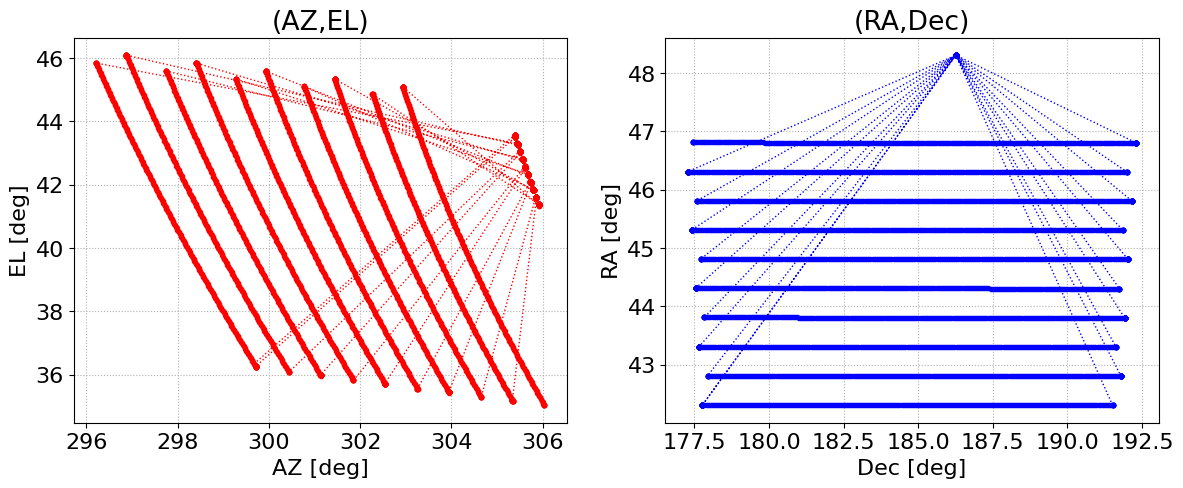

In [6]:
data = pd.read_csv(r"log\azel-20241008150537.log", header=None)

data[0] = data[0].apply(parse_date_to_utc)
obs_dt = data[0] 
az_cmd = data[4]
az_real = data[5]
el_cmd = data[6]
el_real = data[7]

data[['ra_deg', 'dec_deg', 'gl_deg', 'gb_deg', 'equinox']] = pd.DataFrame(data.apply(apply_transform, axis=1).tolist(), index=data.index)

fig,ax = plt.subplots(1,2,figsize=(14,5))

ax[0].plot(az_cmd, el_cmd, ":.r", lw=1)
ax[0].set_xlabel('AZ [deg]')
ax[0].set_ylabel('EL [deg]')
ax[0].set_title('(AZ,EL)')

ax[1].plot(data['ra_deg'], data['dec_deg'], ":.b", lw=1)
ax[1].set_ylabel("RA [deg]")
ax[1].set_xlabel("Dec [deg]")
ax[1].set_title("(RA,Dec)")